In [34]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import matplotlib.pyplot as plt
from basic_utils import *
from pricing import *

pd.options.display.float_format = '{:,.3f}'.format

<Figure size 432x288 with 0 Axes>

In [3]:
symbol = '^VIX'
# excl_list = ['ORBK']
# profile.drop(profile[profile.symbol.isin(excl_list)].index, inplace=True)

### Get universe pricing

In [4]:
# Load pricing, refresh once
symbols_list = config['benchmarks'] + config['risk']
%time px_set = get_mults_pricing(symbols_list, freq, 'close')

Retrieved pricing for ^DJI
Retrieved pricing for ^IXIC
Retrieved pricing for ^GSPC
Retrieved pricing for ^RUT
Retrieved pricing for ^VIX
CPU times: user 200 ms, sys: 18.5 ms, total: 219 ms
Wall time: 1.2 s


### In one shot

### Step-by-step

In [112]:
risk_symbol = '^VIX'
bench_symbol = '^GSPC'

In [408]:
# All daily pricing is downloaded for 10 years by default
get_pricing('^VIX', '1d', '30y');
get_pricing('^GSPC', '1d', '30y');

Getting pricing interval of ^VIX interval: 1d, range: 30y
Getting pricing interval of ^GSPC interval: 1d, range: 30y


In [113]:
# Retrieves historical pricing
secpx = get_symbol_pricing('^VIX', freq)
secpx.rename(columns={'close': risk_symbol}, inplace=True)
secpx.drop(columns=['volume'], inplace=True)
secpx.set_index(secpx.index.astype(np.datetime64), inplace=True)

closepx = secpx[risk_symbol]
openpx = secpx['open']
lowpx = secpx['low']
highpx = secpx['high']

closepx_1d_shift = closepx.shift(1)
pct_chg = closepx.pct_change()

SPY = get_symbol_pricing('^GSPC', freq) # SPY pricing
SPY.set_index(SPY.index.astype(np.datetime64), inplace=True)

secpx[bench_symbol] = SPY['close']
SPY_close = secpx[bench_symbol]
SPY_pct_chg = secpx[bench_symbol].pct_change()

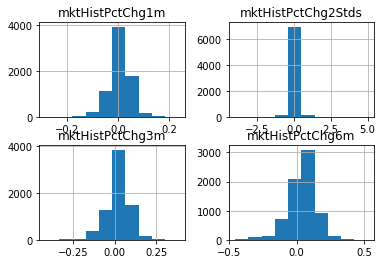

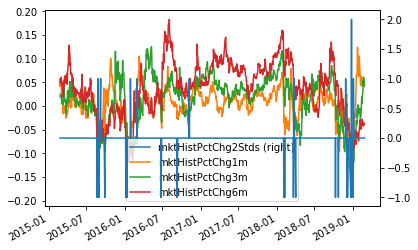

In [114]:
# historical returns for 1, 3, and 6 months
secpx['mktHistPctChg2Stds'] = SPY_pct_chg.apply(sign_compare, args=(SPY_pct_chg.std() * 2,))
secpx['mktHistPctChg1m'] = SPY_close.pct_change(periods=20)
secpx['mktHistPctChg3m'] = SPY_close.pct_change(periods=60)
secpx['mktHistPctChg6m'] = SPY_close.pct_change(periods=120)

show = ['mktHistPctChg2Stds', 'mktHistPctChg1m', 'mktHistPctChg3m', 'mktHistPctChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot(secondary_y='mktHistPctChg2Stds');

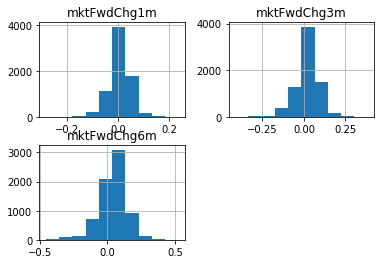

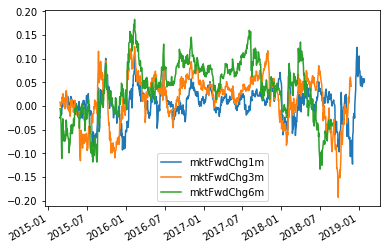

In [115]:
# Forward returns, 1w, 1m, 3m
SPY_close.pct_change(5).shift(-5)
secpx['mktFwdChg1m'] = SPY_close.pct_change(20).shift(-20)
secpx['mktFwdChg3m'] = SPY_close.pct_change(60).shift(-60)
secpx['mktFwdChg6m'] = SPY_close.pct_change(120).shift(-120)

show = ['mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot();

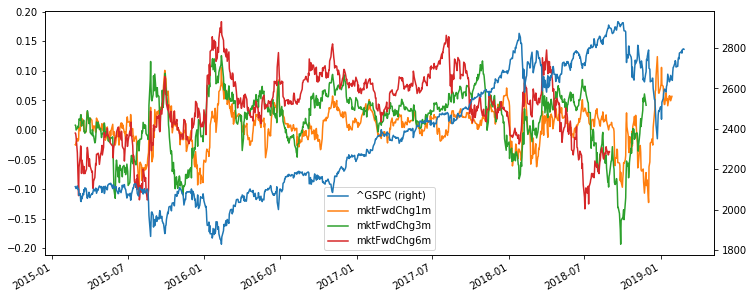

In [116]:
show = [bench_symbol, 'mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
secpx[show].tail(252*4).plot(secondary_y=bench_symbol, figsize=(12,5));

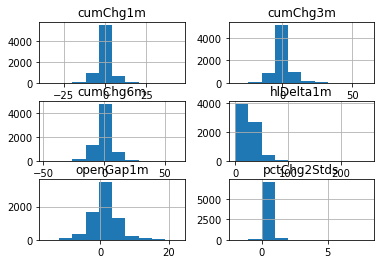

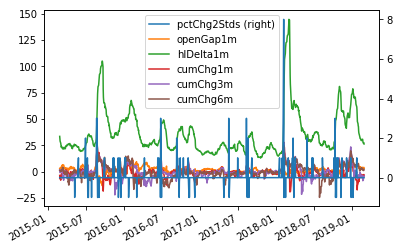

In [117]:
# cumulative deltas and gap analysis
secpx['pctChg2Stds'] = pct_chg.apply(sign_compare, args=(pct_chg.std() * 2,))
secpx['openGap1m'] = (openpx - closepx.shift(1)).rolling(20).sum()
secpx['hlDelta1m'] = (highpx - lowpx).rolling(20).sum()
secpx['cumChg1m'] = (closepx - closepx.shift(1)).rolling(20).sum()
secpx['cumChg3m'] = (closepx - closepx.shift(1)).rolling(60).sum()
secpx['cumChg6m'] = (closepx - closepx.shift(1)).rolling(120).sum()

# cumulative gaps relative to LT means
# secpx['cumChgPctLT'] = secpx['cumChg1m'] / closepx.mean()

show = ['pctChg2Stds', 'openGap1m', 'hlDelta1m', 'cumChg1m', 'cumChg3m', 'cumChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot(secondary_y='pctChg2Stds');

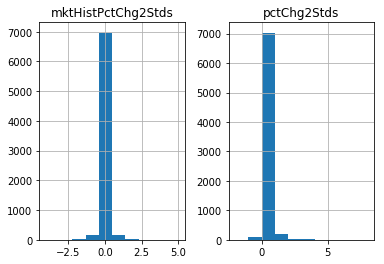

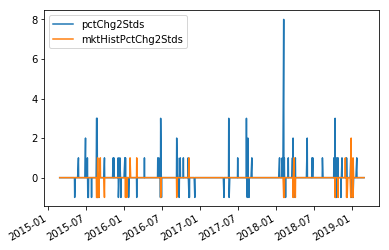

In [118]:
show = ['pctChg2Stds', 'mktHistPctChg2Stds']
secpx[show].hist();
secpx[show].tail(252*4).plot();

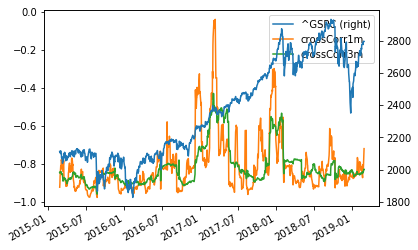

In [119]:
# rolling SPY correlations
secpx['crossCorr1m'] = closepx.pct_change().rolling(20).corr(SPY_pct_chg)
secpx['crossCorr3m'] = closepx.pct_change().rolling(60).corr(SPY_pct_chg)

show = [bench_symbol, 'crossCorr1m', 'crossCorr3m']
secpx[show].tail(252*4).plot(secondary_y=bench_symbol);
# closepx.pct_change().corr(SPY_pct_chg)

In [120]:
# show correlations with Y variables
show = ['mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
secpx.corr()[show]

,mktFwdChg1m,mktFwdChg3m,mktFwdChg6m
high,0.040,0.055,0.092
low,0.046,0.064,0.099
open,0.043,0.057,0.093
^VIX,0.045,0.060,0.095
^GSPC,-0.057,-0.111,-0.146
mktHistPctChg2Stds,-0.032,-0.027,-0.014
mktHistPctChg1m,-0.048,-0.015,0.012
mktHistPctChg3m,-0.019,0.065,0.040
mktHistPctChg6m,0.011,0.042,0.069
mktFwdChg1m,1.000,0.576,0.453


In [121]:
# describe full set before dropping unneeded columns
secpx.describe().T

,count,mean,std,min,25%,50%,75%,max
high,"7,345.000",20.067,8.231,9.310,14.240,17.980,23.540,89.530
low,"7,345.000",18.654,7.436,8.560,13.160,16.840,22.060,72.760
open,"7,345.000",19.334,7.862,9.010,13.630,17.440,22.800,80.740
^VIX,"7,345.000",19.268,7.793,9.140,13.610,17.400,22.660,80.860
^GSPC,"7,345.000","1,217.533",615.868,295.460,782.720,"1,178.900","1,451.700","2,930.750"
mktHistPctChg2Stds,"7,345.000",-0.004,0.288,-4.000,0.000,0.000,0.000,5.000
mktHistPctChg1m,"7,325.000",0.007,0.042,-0.282,-0.015,0.011,0.031,0.235
mktHistPctChg3m,"7,285.000",0.020,0.071,-0.413,-0.013,0.027,0.061,0.382
mktHistPctChg6m,"7,225.000",0.041,0.103,-0.454,-0.007,0.049,0.099,0.524
mktFwdChg1m,"7,325.000",0.007,0.042,-0.282,-0.015,0.011,0.031,0.235


In [122]:
not_show = ['high', 'open', 'low', bench_symbol]
ml_ds_cols = [x for x in secpx.columns.tolist() if x not in not_show]
ml_ds_df = secpx[ml_ds_cols].copy()

In [123]:
# ML semi-ready, needs pre-processing
ml_ds_df.describe().T

,count,mean,std,min,25%,50%,75%,max
^VIX,"7,345.000",19.268,7.793,9.140,13.610,17.400,22.660,80.860
mktHistPctChg2Stds,"7,345.000",-0.004,0.288,-4.000,0.000,0.000,0.000,5.000
mktHistPctChg1m,"7,325.000",0.007,0.042,-0.282,-0.015,0.011,0.031,0.235
mktHistPctChg3m,"7,285.000",0.020,0.071,-0.413,-0.013,0.027,0.061,0.382
mktHistPctChg6m,"7,225.000",0.041,0.103,-0.454,-0.007,0.049,0.099,0.524
mktFwdChg1m,"7,325.000",0.007,0.042,-0.282,-0.015,0.011,0.031,0.235
mktFwdChg3m,"7,285.000",0.020,0.071,-0.413,-0.013,0.027,0.061,0.382
mktFwdChg6m,"7,225.000",0.041,0.103,-0.454,-0.007,0.049,0.099,0.524
pctChg2Stds,"7,345.000",0.028,0.276,-2.000,0.000,0.000,0.000,8.000
openGap1m,"7,325.000",1.294,3.976,-15.890,-0.920,1.380,3.300,22.750


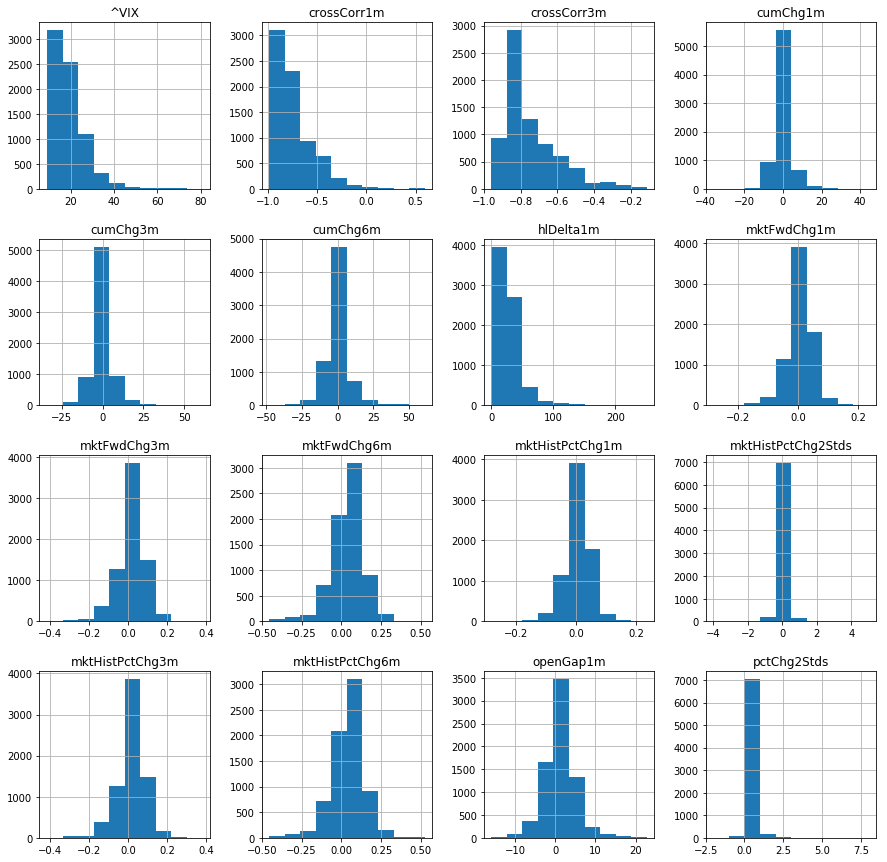

In [92]:
# series distributions
ml_ds_df.hist(figsize=(15,15));

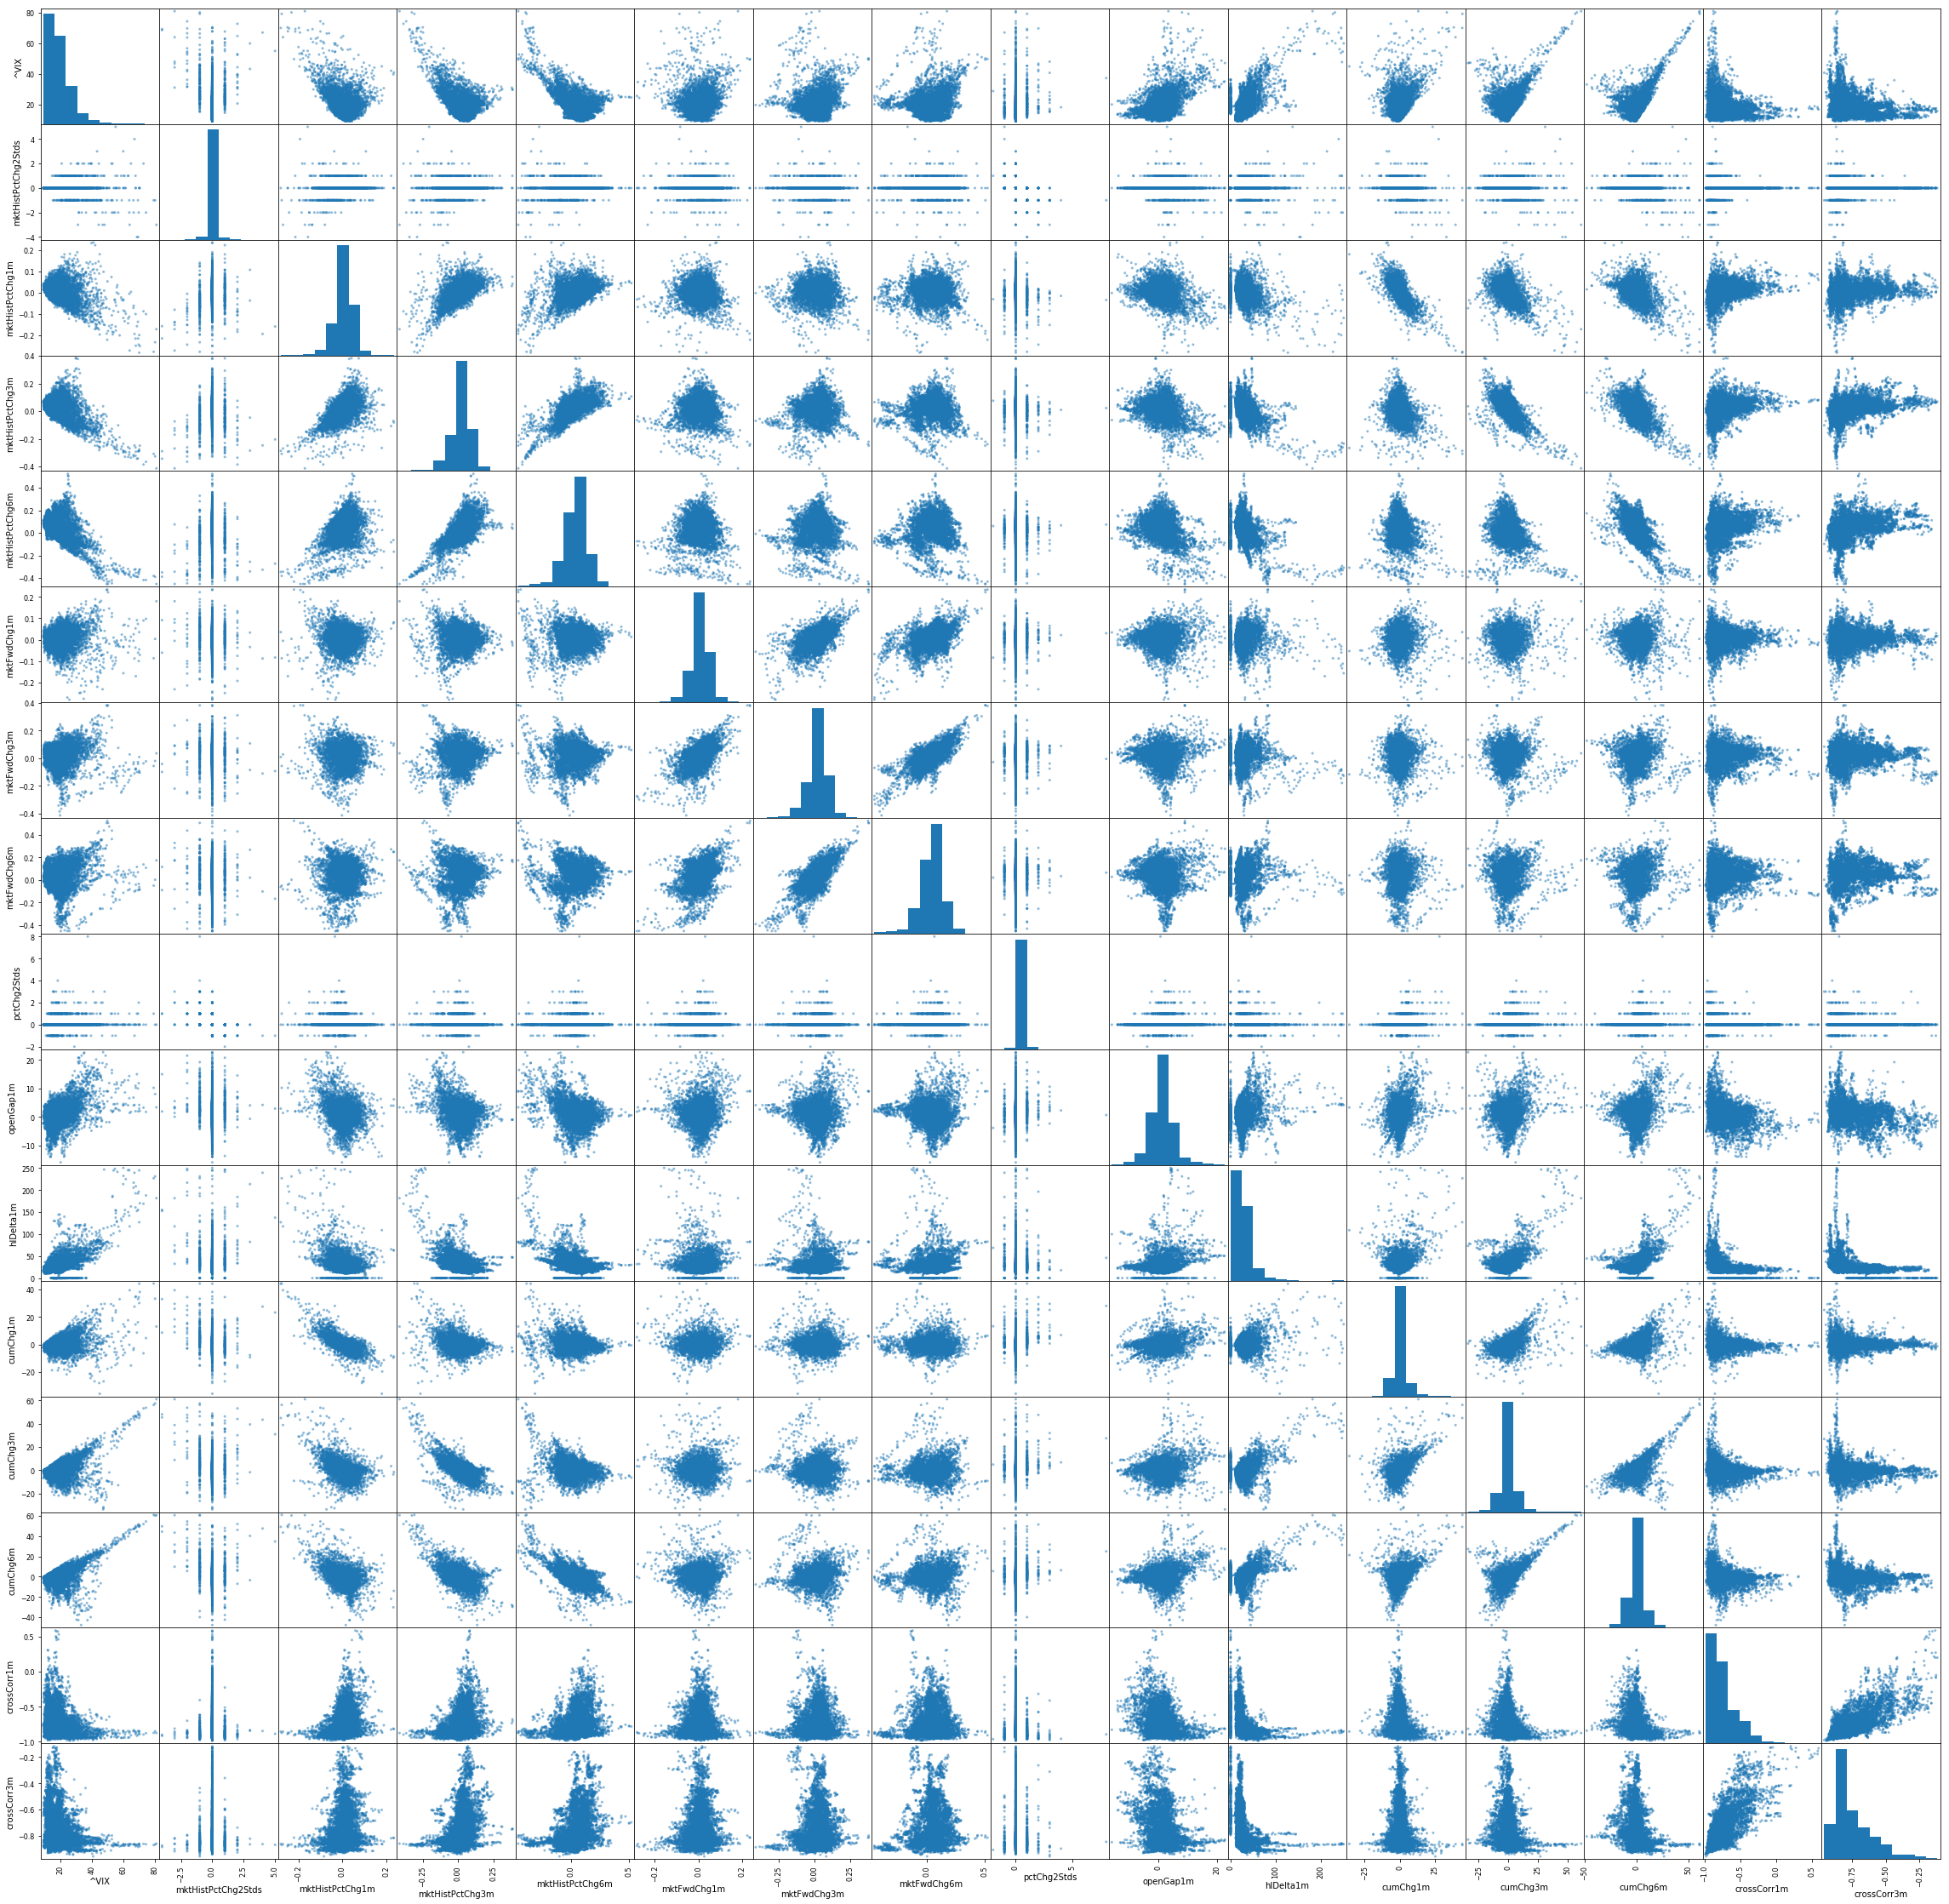

In [91]:
# scatter plots
pd.plotting.scatter_matrix(ml_ds_df, figsize=(40, 40));

In [124]:
ds_name = 'ds_macro_vix_'
update_fmt = 'Added {} to {} dataset'

In [125]:
# Discretize forward returns into consistent classes
class_cols = ['mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
cut_range = [-1, -0.1, .0, .02, .1, 1.]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
for c in class_cols: 
    ml_ds_df[c] = pd.cut(ml_ds_df[c], cut_range, labels=fwd_ret_labels)

In [126]:
# Split into different datasets with Y at the end, save in S3
Xs = [x for x in ml_ds_cols if x not in class_cols]
for y in class_cols:
    ds_cols = Xs + [y] # join Xs and Y
    fname = ds_name + y # dataset name
    # drop nas and shuffle the data    
    ml_ds_df_y = ml_ds_df[ds_cols].dropna().sample(frac=1)
    csv_store(ml_ds_df_y, 'training/', csv_ext.format(fname))
    print(update_fmt.format(len(ml_ds_df_y), fname))

Saved training/ds_macro_vix_mktFwdChg1m.csv
Added 7205 to ds_macro_vix_mktFwdChg1m dataset
Saved training/ds_macro_vix_mktFwdChg3m.csv
Added 7165 to ds_macro_vix_mktFwdChg3m dataset
Saved training/ds_macro_vix_mktFwdChg6m.csv
Added 7105 to ds_macro_vix_mktFwdChg6m dataset


In [128]:
# last uploaded dataset
ml_ds_df_y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7105 entries, 2016-04-19 to 2001-08-20
Data columns (total 14 columns):
^VIX                  7105 non-null float64
mktHistPctChg2Stds    7105 non-null float64
mktHistPctChg1m       7105 non-null float64
mktHistPctChg3m       7105 non-null float64
mktHistPctChg6m       7105 non-null float64
pctChg2Stds           7105 non-null float64
openGap1m             7105 non-null float64
hlDelta1m             7105 non-null float64
cumChg1m              7105 non-null float64
cumChg3m              7105 non-null float64
cumChg6m              7105 non-null float64
crossCorr1m           7105 non-null float64
crossCorr3m           7105 non-null float64
mktFwdChg6m           7105 non-null category
dtypes: category(1), float64(13)
memory usage: 784.2 KB


### Other code

In [29]:
# quick overview on statistically significnat pct moves
# pd.value_counts(secpx['pct_chg_std']).sort_index()
# secpx['pct_chg_std'][secpx['pct_chg_std'] > 15]
# secpx.loc['2018-02',:]